## Define cases

In [1]:
# Define the various scenarios
N = 4 #Number of grids

experiments = [
    dict(modfile='ces', freeparam='xi', range=(0.2,1.0,N)),
    dict(modfile='exponential', freeparam='alpha', range=(0.1,10,N)),
    dict(modfile='translog',  freeparam='sigma', range=(0.1,10,N)),
    dict(modfile ='cesds_EL', freeparam='mu', range=(1.1,2,N)),
    dict(modfile ='cesds_EL', freeparam='varphi', range=(0.2,10,N)),
    dict(modfile ='cesds_EI', freeparam='zeta', range=(0.3,0.9,N)),
    dict(modfile ='cesds_EI', freeparam='mu', range=(1.1,2,N)),
    dict(modfile ='translog_ELEI', freeparam='sigma', range=(1.2,10,N), fixedparam = 'varphi', value=0.25),
    dict(modfile ='translog_ELEI', freeparam='sigma',range=(1.2,10,N), fixedparam = 'varphi', value=5) 
]

## Compute Welfares

In [2]:
# Serial evaluation -> for each case compute ce,po and welfare gains
from BGM_solver import compute_case
all_welfares = [compute_case(exp) for exp in experiments];

    calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [3]:
import pandas #python library for tables
# Create the table for all paramter values, ce and po welfare, gains and export to excel
df = pandas.concat(all_welfares, axis=1)
df.to_excel('output/welfare_gains.xls')

# Uncomment the line below to see the table
#df

## Make plots

In [4]:
from matplotlib import pyplot as plt #python library for plots
%matplotlib inline

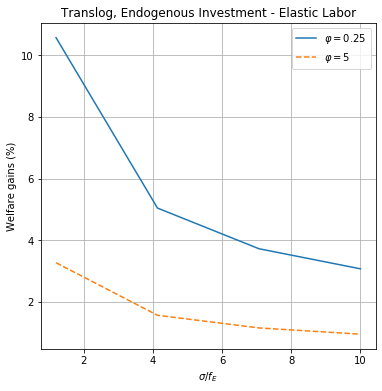

In [5]:
fig = plt.figure(figsize=(6,6))
plt.plot(df['translog_ELEI_varphi025_sigma'],df['translog_ELEI_varphi025_sigma_gain'], label="$\\varphi = 0.25$")
plt.plot(df['translog_ELEI_varphi5_sigma'],df['translog_ELEI_varphi5_sigma_gain'], label="$\\varphi = 5$", linestyle='--', )
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\sigma/ f_{E}$")
#yl = plt.ylim()
#plt.ylim(0,yl[1])
plt.title("Translog, Endogenous Investment - Elastic Labor")
plt.grid()
plt.legend(loc='best')
# xlim(4,8)
# ylim(0,0.2)


plt.savefig('output/plots/BGM_welfare_gains_general_model.png')
plt.savefig('output/plots/BGM_welfare_gains_general_model.pdf')
plt.savefig('output/plots/BGM_welfare_gains_general_model.svg')

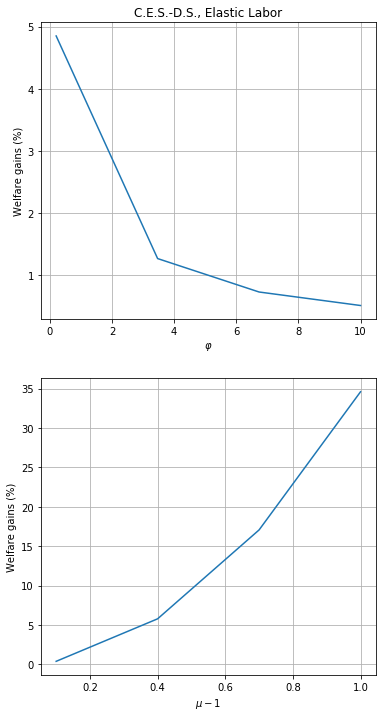

In [6]:
fig = plt.figure(figsize=(6,12))

plt.subplot(211)
plt.plot(df['cesds_EL_varphi'],df['cesds_EL_varphi_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\varphi$")
#yl = plt.ylim()
#plt.ylim(0,yl[1])
plt.title('C.E.S.-D.S., Elastic Labor')
plt.grid()
# xlim(4,8)
# ylim(0,0.2)

plt.subplot(212)
plt.plot(df['cesds_EL_mu']-1,df['cesds_EL_mu_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\mu-1$")
#yl = plt.ylim()
#plt.ylim(0,yl[1])
#plt.title("C.E.S.-DS, Elastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)

plt.savefig('output/plots/BGM_welfare_gains_EL.png')
plt.savefig('output/plots/BGM_welfare_gains_EL.pdf')
plt.savefig('output/plots/BGM_welfare_gains_EL.svg')

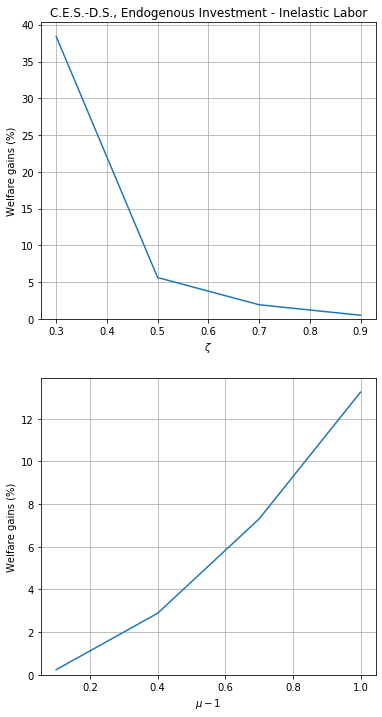

In [7]:
fig = plt.figure(figsize=(6,12))


plt.subplot(211)
plt.plot(df['cesds_EI_zeta'],df['cesds_EI_zeta_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\zeta$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("C.E.S.-D.S., Endogenous Investment - Inelastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)


plt.subplot(212)
plt.plot(df['cesds_EI_mu']-1,df['cesds_EI_mu_gain'])
plt.ylabel('Welfare gains (%)')

plt.xlabel("$\\mu-1$")
yl = plt.ylim()
plt.ylim(0,yl[1])
#plt.title("C.E.S.-DS, Endogenous Investment - Inelastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)

plt.savefig('output/plots/BGM_welfare_gains_EI.png')
plt.savefig('output/plots/BGM_welfare_gains_EI.pdf')
plt.savefig('output/plots/BGM_welfare_gains_EI.svg')

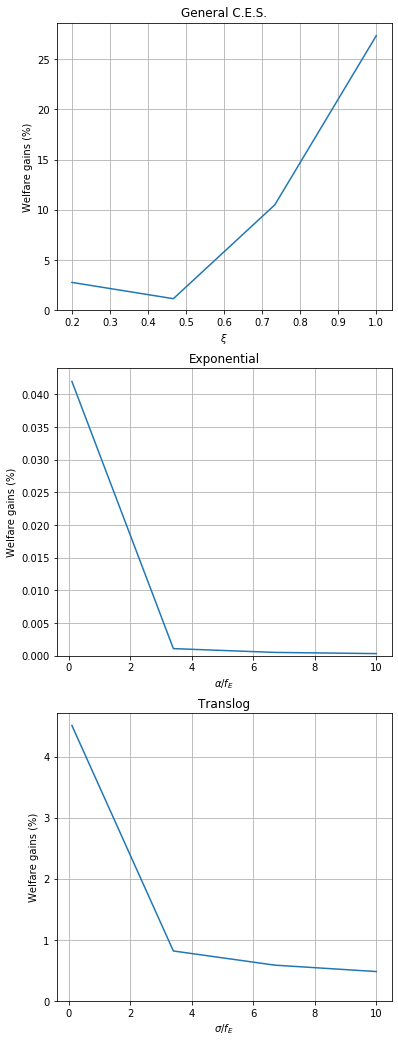

In [8]:
### Baseline model ###
fig = plt.figure(figsize=(6,18))
plt.subplot(311)
plt.plot(df['ces_xi'],df['ces_xi_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\xi$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("General C.E.S.")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(312)
plt.plot(df['exponential_alpha'],df['exponential_alpha_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Exponential")
plt.xlabel("$\\alpha/ f_{E}$")
plt.ylabel('Welfare gains (%)')
plt.subplot(313)
plt.plot(df['translog_sigma'],df['translog_sigma_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Translog")
plt.xlabel("$\\sigma/ f_{E}$")
plt.ylabel('Welfare gains (%)')
plt.savefig('output/plots/BGM_welfare_gains.png')
plt.savefig('output/plots/BGM_welfare_gains.pdf')
plt.savefig('output/plots/BGM_welfare_gains.svg')
